In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from collections import Counter

In [2]:
seed = 0
instance = "14_instance -- 14 containers -- 3 carriers -- 4 chassis -- 10-day horizon"
file_name = "14_instance.csv"

#initialize integer params
num_containers = 14
num_carriers = 3
num_chassis = 4
fixed_stack_cost = 400
daily_stack_cost = 15

#define horizon & # of arrivals (usually every 1,3 days, i think)
num_ship_arrivals = 5
horizon = 10

#initializing choice ranges for carriers
alphabet = string.ascii_lowercase.split()[0][0:num_carriers]
used_alphabet = list(alphabet)
demurrage_period_choices = [2,3,4,5,6,7]
detention_period_choices = [14,21,28]
demurrage_cost_choices = np.arange(100,350,step=50)
detention_cost_choices = np.arange(50,200,step=50)

#initialize lists/dicts + travel times to each destination
containers,carriers,release_dates,transload_pt,priority = [],[],[],[],[]
demurrage_free_period,demurrage_daily_cost,detention_free_period,detention_daily_cost = {},{},{},{}
leg_travel_times = {'leg_1':0.5/8, 'leg_2':1/8, 'leg_3':1/8}  #% of daily shift (8 total hours)

### Container index 

In [3]:
containers = np.arange(1,num_containers+1)

### Assign a Carrier to Container i

In [4]:
np.random.seed(seed)
carriers = np.random.choice(used_alphabet,num_containers)

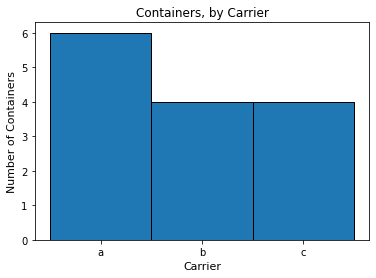

In [5]:
counts, count = Counter(carriers), []
for i in used_alphabet:
    count.append(counts[i])
    
plt.bar(used_alphabet,count,edgecolor='black',width=1.0)
plt.title('Containers, by Carrier')
plt.ylabel('Number of Containers',size=11)
plt.xlabel('Carrier',size=11)
plt.show()

### Release Dates

Selecting one of the ship arrival days, assigning a carrier to that ship, then assigning release dates to each container from the possible carrier arrival days, then plotting arrival schedules 

In [6]:
np.random.seed(seed)
ship_arrival_dates = np.random.choice(horizon,num_ship_arrivals)
release_dates = []

#assign a ship arrival to a carrier
assign_carriers = []
for ship in ship_arrival_dates:
    assign_carriers.append(np.random.choice(used_alphabet))

#make dictionnary for all carrier arrivals
carrier_arrivals, container_arrivals, pl= {},{},[]
for letter in used_alphabet:
    cont_arrivals = []
    ship_arrivals = []
    for arrival in range(num_ship_arrivals):
        if assign_carriers[arrival] == letter:
            ship_arrivals.append(ship_arrival_dates[arrival])
    for i in range(num_containers):
        if carriers[i] == letter:
            cont_arrivals.append(i)
            
    #if no arrivals are from carrier then skip
    if ship_arrivals != []:
        carrier_arrivals[letter] = ship_arrivals
    if cont_arrivals != []:
        container_arrivals[letter] = cont_arrivals
    pl.append(cont_arrivals)
        
#select a release date from possible carrier arrival dates
for i in carriers:
    release_dates.append(np.random.choice(carrier_arrivals[i]))

release_dates = np.array(release_dates)

#get container arrival dates, by carrier (to plot)
for letter in used_alphabet:
    cont_arrivals = []
    for i in range(num_containers):
        if carriers[i] == letter:
            cont_arrivals.append(release_dates[i])
    if cont_arrivals != []:
        container_arrivals[letter] = cont_arrivals
    pl.append(cont_arrivals)

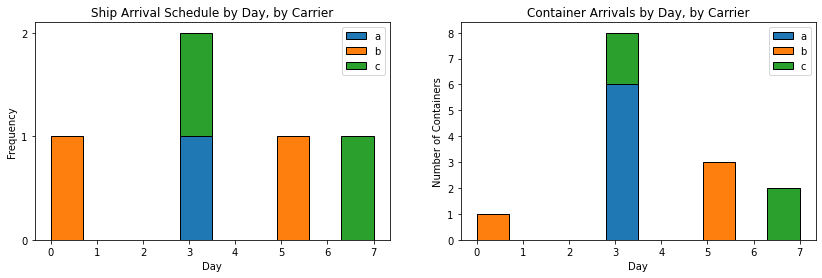

In [7]:
#getting max for figure
arrivals = list(ship_arrival_dates)
max_day_arrivals = max(set(arrivals),key=arrivals.count) 

#plotting ship arrival schedule and container arrival schedule for instance 
plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
data = []
for letter in carrier_arrivals:
    data.append(carrier_arrivals[letter])
plt.hist(data,bins=horizon,edgecolor='black',stacked=True,label=used_alphabet)
plt.title('Ship Arrival Schedule by Day, by Carrier')
plt.xlabel('Day')
plt.ylabel('Frequency')
plt.legend()
plt.yticks(np.arange(0,max_day_arrivals,step=1))

plt.subplot(1,2,2)
data = []
for letter in container_arrivals:
    data.append(container_arrivals[letter])
plt.hist(data,bins=horizon,edgecolor='black',stacked=True,label=used_alphabet)
plt.title('Container Arrivals by Day, by Carrier')
plt.xlabel('Day')
plt.ylabel('Number of Containers')
plt.legend()

plt.show()

### Transload Processing Times (using Tria(1,2,5) distribution)

[3.15129029 2.8166907  2.66303577 2.37014403]


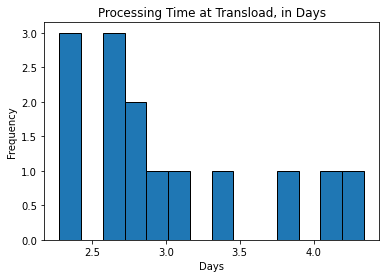

In [8]:
np.random.seed(seed)
transload_pt = np.random.triangular(1,2,5,size=num_containers)
print(transload_pt[1:5])

plt.hist(transload_pt,bins=14,edgecolor='black')
plt.title('Processing Time at Transload, in Days')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.show()

### Priority (randomly assign 1-->num_containers, all unique)

In [9]:
np.random.seed(seed)
priority = np.random.choice(np.arange(1,num_containers+1),num_containers,replace=False)

### Carrier Associated Costs

In [10]:
#choosing from possible period and cost values (define at beginning)
np.random.seed(seed)
for j in range(num_carriers):
    demurrage_free_period[alphabet[j]] = np.random.choice(demurrage_period_choices)
    demurrage_daily_cost[alphabet[j]] = np.random.choice(demurrage_cost_choices)
    detention_free_period[alphabet[j]] = np.random.choice(detention_period_choices)
    detention_daily_cost[alphabet[j]] = np.random.choice(detention_cost_choices) 

### Merging Parameters & Write to File_name

In [11]:
columns = np.empty(num_containers)
columns[:] = np.nan
columns = list(columns)
columns[0] = instance
export,export[:] = np.empty([12,num_containers]),np.nan
export = pd.DataFrame(export,columns=columns)

export.iloc[0,0],export.iloc[0,1],export.iloc[0,2] = num_containers,num_carriers,num_chassis
export.iloc[1] = containers
export.iloc[2] = carriers
export.iloc[3] = release_dates
export.iloc[4] = transload_pt
export.iloc[5] = priority
export.iloc[10,0],export.iloc[10,1] = fixed_stack_cost,daily_stack_cost
#write carrier associated costs
k = 0
for c in used_alphabet:
    export.iloc[6,k*2],export.iloc[7,k*2],export.iloc[8,k*2],export.iloc[9,k*2] = c,c,c,c
    export.iloc[6,k*2+1],export.iloc[7,k*2+1],export.iloc[8,k*2+1],export.iloc[9,k*2+1] = demurrage_free_period[c],demurrage_daily_cost[c],detention_free_period[c],detention_daily_cost[c]
    k+=1
    
#write travel times for each leg
l = 0
for leg in leg_travel_times:
    export.iloc[11,l*2] = leg
    export.iloc[11,l*2+1] = leg_travel_times[leg]
    l+=1

export

,14_instance -- 14 containers -- 3 carriers -- 4 chassis -- 10-day horizon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,14,3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,3,4,5,6,7,8,9,10,11,12,13,14
2,a,b,a,b,b,c,a,c,a,a,a,c,b,c
3,3,5,3,5,5,3,3,7,3,3,3,3,0,7
4,2.67315,3.15129,2.81669,2.66304,2.37014,2.93862,2.40213,3.86038,4.33966,2.27994,3.41908,2.62234,2.72328,4.0551
5,9,7,5,12,3,14,10,2,8,11,4,1,6,13
6,a,6,b,4,c,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,a,100,b,300,c,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,a,21,b,28,c,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,a,100,b,50,c,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#write to csv file. Make sure to close excel file if overwritting 
export.to_csv(file_name,index=False)